In [1]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Assume the 'src' folder is one level up from the current notebook's directory
# This might need adjustment based on your exact directory structure
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the project root to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to sys.path.")

Added 'd:\10academy\week_8_9_Improved_detection_of_ fraud_cases_for_e_commerce_and_bank_transactions' to sys.path.


In [2]:
# =============================================================================
# 02_bank_fraud_eda_preprocessing.ipynb
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions from src
from src.data_cleaning import clean_bank_data
from src.feature_engineering import create_bank_features
from src.model_utils import preprocess_for_modeling # We'll call this at the very end of preprocessing

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries and custom modules loaded successfully!")

Libraries and custom modules loaded successfully!


In [3]:
# --- Load Data ---
print("\n--- Loading Data ---")
try:
    df_creditcard = pd.read_csv('../data/creditcard.csv')
    print("creditcard.csv loaded.")
except FileNotFoundError:
    print("Error: Ensure 'data' folder is in the parent directory and contains creditcard.csv.")
    raise # Re-raise to stop execution if data is missing

print("Credit Card Data shape:", df_creditcard.shape)

# Display head to understand columns
print("\nCredit Card Data Head:")
print(df_creditcard.head())


--- Loading Data ---
creditcard.csv loaded.
Credit Card Data shape: (284807, 31)

Credit Card Data Head:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.27

In [4]:
# =============================================================================
# Task 1 - Data Analysis and Preprocessing
# =============================================================================

# --- Handle Missing Values & Data Cleaning ---
# Using the function from src/data_cleaning.py
df_creditcard = clean_bank_data(df_creditcard.copy())

Starting bank data cleaning...
Removed 1081 duplicate rows.
Bank data cleaning complete.



--- Exploratory Data Analysis (Credit Card) ---


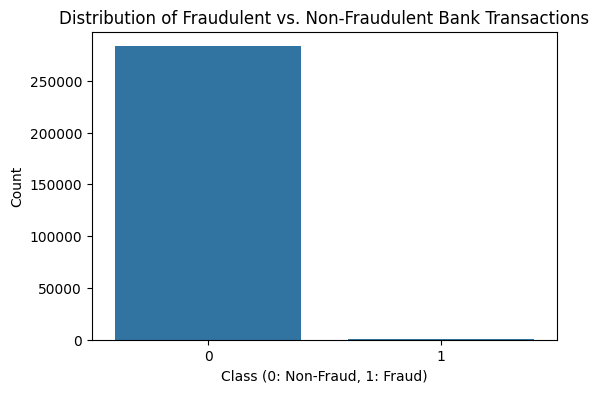


Class Distribution:
Class
0    99.83329
1     0.16671
Name: proportion, dtype: float64
Class Imbalance: Fraudulent transactions make up 0.1667% of the data.


In [5]:
# =============================================================================
# Exploratory Data Analysis (EDA) - (Keep in notebook for visualization)
# =============================================================================
print("\n--- Exploratory Data Analysis (Credit Card) ---")

# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df_creditcard)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Bank Transactions')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

fraud_percentage_bank = df_creditcard['Class'].value_counts(normalize=True) * 100
print(f"\nClass Distribution:\n{fraud_percentage_bank}")
print(f"Class Imbalance: Fraudulent transactions make up {fraud_percentage_bank[1]:.4f}% of the data.")

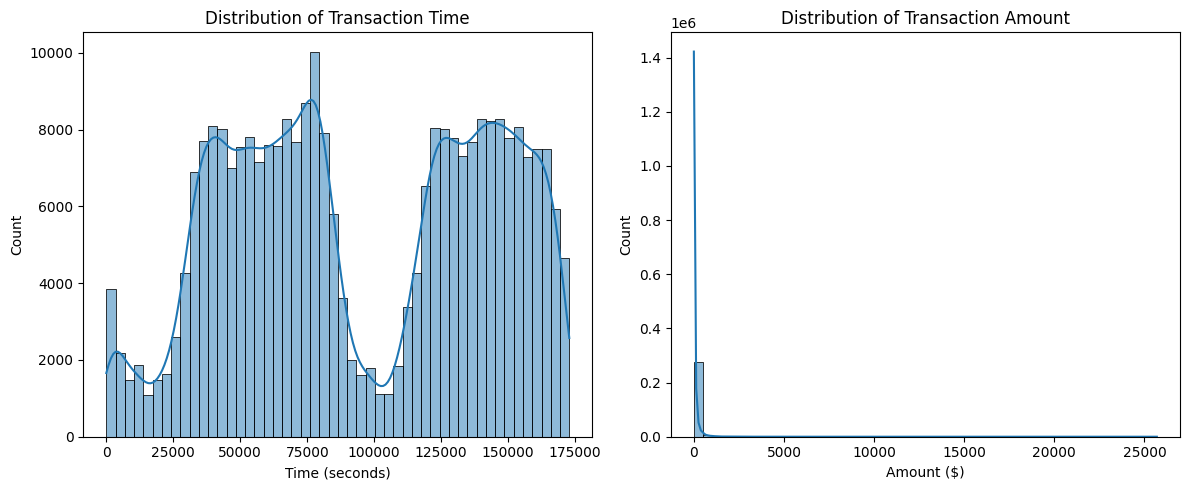


Time Statistics:
count    283726.000000
mean      94811.077600
std       47481.047891
min           0.000000
25%       54204.750000
50%       84692.500000
75%      139298.000000
max      172792.000000
Name: Time, dtype: float64

Amount Statistics:
count    283726.000000
mean         88.472687
std         250.399437
min           0.000000
25%           5.600000
50%          22.000000
75%          77.510000
max       25691.160000
Name: Amount, dtype: float64


In [6]:
# Distribution of 'Time' and 'Amount'
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_creditcard['Time'], bins=50, kde=True)
plt.title('Distribution of Transaction Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(df_creditcard['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount ($)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\nTime Statistics:")
print(df_creditcard['Time'].describe())
print("\nAmount Statistics:")
print(df_creditcard['Amount'].describe())

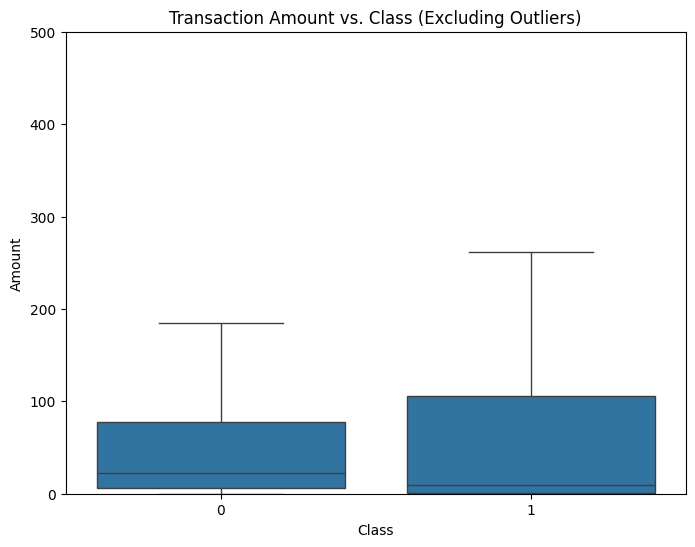

In [7]:
# Bivariate analysis: Amount vs. Class
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df_creditcard, showfliers=False) # showfliers=False to ignore extreme outliers
plt.title('Transaction Amount vs. Class (Excluding Outliers)')
plt.ylim(0, 500) # Zoom in for better visualization of main distribution
plt.show()

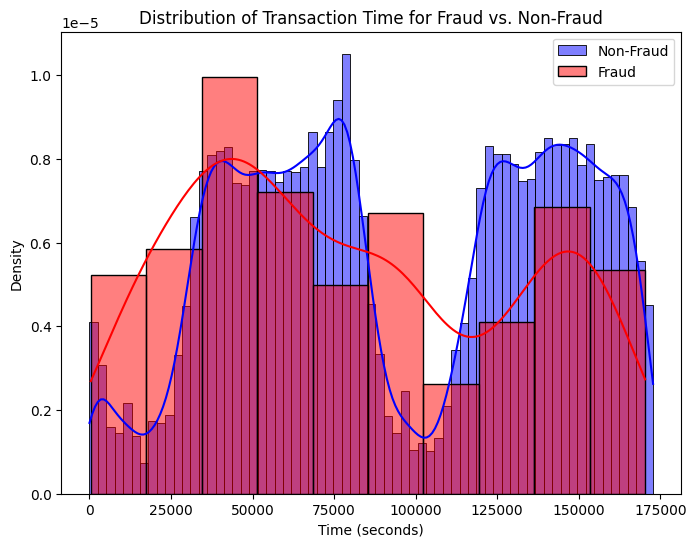


Correlation of features with 'Class' (top/bottom 5):
Class    1.000000
V11      0.149067
V4       0.129326
V2       0.084624
V19      0.033631
V8       0.033068
Name: Class, dtype: float64
V16   -0.187186
V10   -0.206971
V12   -0.250711
V14   -0.293375
V17   -0.313498
Name: Class, dtype: float64


In [8]:
# Bivariate analysis: Time vs. Class
plt.figure(figsize=(8, 6))
sns.histplot(df_creditcard[df_creditcard['Class'] == 0]['Time'], color='blue', kde=True, stat='density', alpha=0.5, label='Non-Fraud')
sns.histplot(df_creditcard[df_creditcard['Class'] == 1]['Time'], color='red', kde=True, stat='density', alpha=0.5, label='Fraud')
plt.title('Distribution of Transaction Time for Fraud vs. Non-Fraud')
plt.xlabel('Time (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()

print("\nCorrelation of features with 'Class' (top/bottom 5):")
correlations = df_creditcard.corr()['Class'].sort_values(ascending=False)
print(correlations.head(6))
print(correlations.tail(5))

In [9]:
# --- Feature Engineering ---
# Using the function from src/feature_engineering.py
df_creditcard = create_bank_features(df_creditcard.copy())

print("\nCredit Card Data with new time-based features head:")
print(df_creditcard[['Time', 'hour_of_day', 'day_of_week']].head())

--- Starting Feature Engineering for Bank Data ---
--- Bank Feature Engineering Complete ---

Credit Card Data with new time-based features head:
   Time hour_of_day day_of_week
0   0.0           0           0
1   0.0           0           0
2   1.0           0           0
3   1.0           0           0
4   2.0           0           0


In [10]:
# --- Data Transformation (Preparation for Modeling) ---
# Separate features and target
X_bank = df_creditcard.drop(columns=['Class'])
y_bank = df_creditcard['Class']

print("\nFeatures selected for modeling (Bank):")
print(X_bank.head())
print("\nTarget variable (Bank):")
print(y_bank.head())

# =========================================================================
# Crucial diagnostic: Check cardinality of all columns
# =========================================================================
print("\n--- Cardinality Check for Bank Data ---")
potential_problem_cols = []
for col in X_bank.columns:
    num_unique = X_bank[col].nunique()
    print(f"Column '{col}': {num_unique} unique values (Dtype: {X_bank[col].dtype})")
    # Heuristic: if a supposedly categorical column has more than, say, 50 unique values
    # it might be problematic for one-hot encoding if it's not truly categorical.
    if (X_bank[col].dtype == 'object' or str(X_bank[col].dtype) == 'category') and num_unique > 50:
        print(f"  --> WARNING: High cardinality for a categorical column: {col}")
        potential_problem_cols.append(col)
    elif X_bank[col].dtype in [np.number, 'int64', 'float64'] and num_unique > 50 and col in ['hour_of_day', 'day_of_week']:
         print(f"  --> WARNING: '{col}' is numerical but expected to be categorical with low unique values. Check feature engineering.")
         potential_problem_cols.append(col)


if potential_problem_cols:
    print("\nIdentified potential high-cardinality/mis-typed columns:")
    for col in potential_problem_cols:
        print(f"- {col}")
    print("Please review your feature engineering for these columns, especially their data types and derivation.")
# =========================================================================


# Define categorical and numerical features for preprocessing function
# The lists should be defined *after* any necessary dtype conversions for 'category'
categorical_features_bank = [col for col in X_bank.select_dtypes(include='category').columns]
numerical_features_bank = [col for col in X_bank.select_dtypes(include=np.number).columns]

print(f"\nFinal numerical features for preprocessing: {numerical_features_bank}")
print(f"Final categorical features for preprocessing: {categorical_features_bank}")

# Call the preprocess_for_modeling function from src/model_utils.py
X_train_bank_resampled, X_test_bank, y_train_bank_resampled, y_test_bank, bank_feature_names = \
    preprocess_for_modeling(X_bank.copy(), y_bank.copy(),
                            numerical_features_bank, categorical_features_bank,
                            random_state=42)

# Ensure X_test_bank has column names (needed for SHAP)
X_test_bank = pd.DataFrame(X_test_bank, columns=bank_feature_names)
X_train_bank_resampled = pd.DataFrame(X_train_bank_resampled, columns=bank_feature_names)


Features selected for modeling (Bank):
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V22       V23       V24       V25       V26  \
0  0.098698  0.363787  ...  0.277838 -0.110474  0.066928  0.128539 -0.189115   
1  0.085102 -0.255425  ... -0.638672  0.101288 -0.339846  0.167170  0.125895   
2  0.247676 -1.514654  ...  0.771679  0.909412 -0.689281 -0.327642 -0.139097   
3  0.377436 -1.387024  ...  0.005274 -0.190321 -1.175575  0.647376 -0.221929   
4 -0.270533  0.817739  ...  0.798278 -0.137458  0.141267 -0.206010  0.502

In [11]:

# Save preprocessed dataframes for model training notebook
import pickle
with open('../data/processed_bank_data.pkl', 'wb') as f:
    pickle.dump({
        'X_train_resampled': X_train_bank_resampled,
        'y_train_resampled': y_train_bank_resampled,
        'X_test': X_test_bank,
        'y_test': y_test_bank,
        'feature_names': bank_feature_names
    }, f)
print("\nPreprocessed Bank data saved to ../data/processed_bank_data.pkl")


print("\nBank Data Preprocessing Complete!")


Preprocessed Bank data saved to ../data/processed_bank_data.pkl

Bank Data Preprocessing Complete!
